In [101]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [102]:
!ls

20191023_02_29_blending_unet_b3b5b7_mean_sub_lb660.csv
ens_7_lb662_class_params.txt
ens_7models_tta_lb662.csv
ensemble_csv.ipynb
mean_3dfs.csv
mean_3dfs_tmp.csv
submission_segmentation_and_classifier_lb660.csv
Untitled.ipynb


In [104]:
glob.glob('*.csv')

['20191023_02_29_blending_unet_b3b5b7_mean_sub_lb660.csv',
 'ens_7models_tta_lb662.csv',
 'submission_segmentation_and_classifier_lb660.csv',
 'mean_3dfs_tmp.csv',
 'mean_3dfs.csv']

In [105]:
fns = [
    '20191023_02_29_blending_unet_b3b5b7_mean_sub_lb660.csv',
    'ens_7models_tta_lb662.csv',
    'submission_segmentation_and_classifier_lb660.csv'
]

In [106]:
dfs = [pd.read_csv(x) for x in fns]

In [107]:
for df in dfs:
    df.EncodedPixels = df.EncodedPixels.fillna('')

In [108]:
dfs[0].head(5)

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,8 226 240 10 260 25 352 345 702 347 1052 348 1...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


In [109]:
all(dfs[0].Image_Label.values == dfs[2].Image_Label.values)

True

In [110]:
def rle_decode(mask_rle: str = '', shape: tuple = (350, 525)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    if len(mask_rle) < 1:
        return np.zeros(shape, dtype=np.uint8)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


In [113]:
for df in dfs:
    df['masks'] = df.EncodedPixels.map(lambda x: rle_decode(x))

In [114]:
dfs[0].head(10)

,Image_Label,EncodedPixels,masks
0,002f507.jpg_Fish,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,002f507.jpg_Flower,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,002f507.jpg_Gravel,8 226 240 10 260 25 352 345 702 347 1052 348 1...,"[[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,..."
3,002f507.jpg_Sugar,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0035ae9.jpg_Fish,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
5,0035ae9.jpg_Flower,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6,0035ae9.jpg_Gravel,439 174 785 186 1135 187 1484 190 1684 1 1832 ...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
7,0035ae9.jpg_Sugar,2771 10 3119 19 3462 3 3467 24 3810 36 4159 38...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
8,0038327.jpg_Fish,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
9,0038327.jpg_Flower,142344 7 142692 10 142710 3 143040 25 143389 2...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


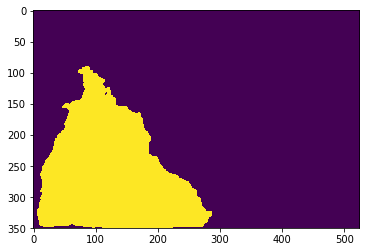

In [115]:
plt.imshow(dfs[0].iloc[7].masks)

In [116]:
mean_masks = []
for i in tqdm(range(len(dfs[0])), total=len(dfs[0])):
    img_masks = []
    for df in dfs:
        img_masks.append(df.iloc[i].masks)
    mean_masks.append((np.mean(img_masks, 0) > 0.5).astype(np.uint8))

100%|██████████| 14792/14792 [00:31<00:00, 471.17it/s]


In [117]:
dfs[0]['mean_masks'] = mean_masks

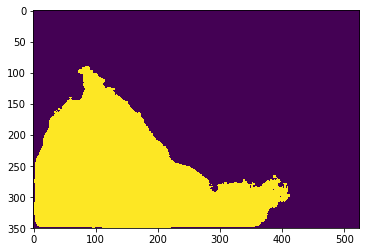

In [118]:
plt.imshow(dfs[0].iloc[7].mean_masks)

In [119]:
dfs[0].EncodedPixels = dfs[0].mean_masks.map(lambda x: mask2rle(x))

In [120]:
dfs[0].head(10)

,Image_Label,EncodedPixels,masks,mean_masks
0,002f507.jpg_Fish,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,002f507.jpg_Flower,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,002f507.jpg_Gravel,5 337 352 345 702 347 1052 347 1401 349 1751 3...,"[[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
3,002f507.jpg_Sugar,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0035ae9.jpg_Fish,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
5,0035ae9.jpg_Flower,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6,0035ae9.jpg_Gravel,159 5 165 1 181 7 197 4 439 174 618 4 776 210 ...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
7,0035ae9.jpg_Sugar,669 7 972 7 1010 20 1312 25 1349 39 1645 97 19...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
8,0038327.jpg_Fish,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
9,0038327.jpg_Flower,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [121]:
dfs[0].to_csv('mean_3dfs_tmp2.csv', columns=['Image_Label', 'EncodedPixels'], index=False)

In [122]:
!md5sum *.csv

98b1b5f3abbad257be86e945008d7894  20191023_02_29_blending_unet_b3b5b7_mean_sub_lb660.csv
927ae361f0d8020d051cd535dbdc9649  ens_7models_tta_lb662.csv
b7a014969ee9dad920038cbb282b2564  mean_3dfs.csv
b7a014969ee9dad920038cbb282b2564  mean_3dfs_tmp.csv
b7a014969ee9dad920038cbb282b2564  mean_3dfs_tmp2.csv
f93d417a4ccccc3f9fb7ff5612de6314  submission_segmentation_and_classifier_lb660.csv


In [79]:
!ls -lh

total 92M
-rw-rw-r-- 1 core core 22M Oct 24 11:38 20191023_02_29_blending_unet_b3b5b7_mean_sub_lb660.csv
-rw-rw-r-- 1 core core 812 Oct 24 11:43 ens_7_lb662_class_params.txt
-rw-rw-r-- 1 core core 21M Oct 24 11:38 ens_7models_tta_lb662.csv
-rw-rw-r-- 1 core core 46K Oct 24 15:06 ensemble_csv.ipynb
-rw-rw-r-- 1 core core 23M Oct 24 15:06 mean_3dfs.csv
-rw-rw-r-- 1 core core 28M Oct 24 11:41 submission_segmentation_and_classifier_lb660.csv
-rw-rw-r-- 1 core core  72 Oct 24 14:26 Untitled.ipynb


In [80]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2448            True  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      12735            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4862           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         56            True  
data-science-bowl-2019                         2020-01-22 23:59:00  Featured          $160,000          8           False  
pku-autonomous-driving                         2020-01-21 23:59:00  Featured           $25,000         28           False  
competit

In [81]:
!kaggle competitions submit -c understanding_cloud_organization -f mean_3dfs.csv -m 'mean df'

100%|██████████████████████████████████████| 22.6M/22.6M [00:13<00:00, 1.72MB/s]
403 - Forbidden


In [82]:
!head -n 2 mean_3dfs.csv

Image_Label,EncodedPixels
002f507.jpg_Fish,
